In [17]:
import numpy as np
import scipy.stats as stats
import pandas as pd
from datetime import datetime
import seaborn as sns
from matplotlib import pyplot as plt

In [18]:
df = pd.read_csv('../data/HRDataset_v14.csv')
df.columns


Index(['Employee_Name', 'EmpID', 'MarriedID', 'MaritalStatusID', 'GenderID',
       'EmpStatusID', 'DeptID', 'PerfScoreID', 'FromDiversityJobFairID',
       'Salary', 'Termd', 'PositionID', 'Position', 'State', 'Zip', 'DOB',
       'Sex', 'MaritalDesc', 'CitizenDesc', 'HispanicLatino', 'RaceDesc',
       'DateofHire', 'DateofTermination', 'TermReason', 'EmploymentStatus',
       'Department', 'ManagerName', 'ManagerID', 'RecruitmentSource',
       'PerformanceScore', 'EngagementSurvey', 'EmpSatisfaction',
       'SpecialProjectsCount', 'LastPerformanceReview_Date', 'DaysLateLast30',
       'Absences'],
      dtype='object')

***Descriptive statistics***

Firstly, the descriptive statistics of Salary column can be useful as it is one of the most interesting columns of this dataset that will be referenced the most in my project.

In [19]:
print('Mean:', df['Salary'].mean())
print('Median:', df['Salary'].median())
print('Standard deviation:', df['Salary'].std())

Mean: 69020.6848874598
Median: 62810.0
Standard deviation: 25156.636929646644


Secondly, the data about the satisfaction of employees. (from 0 to 5)

In [20]:
print('Mean:', df['EmpSatisfaction'].mean())
print('Median:', df['EmpSatisfaction'].median())
print('Standard deviation:', df['EmpSatisfaction'].std())

Mean: 3.8906752411575565
Median: 4.0
Standard deviation: 0.9092410131521376


The information about the age of employees in years can also be interesting and useful for the project. Due to this dataset was created in April 2021, the age of workers will be computed for this date.

In [21]:
df['DOB_Datetime'] = df['DOB'].apply(lambda x: datetime.strptime(x, '%m/%d/%y'))
df['DOB_Datetime'] = df['DOB_Datetime'].apply(lambda x: x.replace(year=x.year - 100) if x.year > 2000 else x)
df['Age'] = datetime.strptime('04/01/2021', '%m/%d/%Y') - df['DOB_Datetime']
df['Age'] = df['Age'].apply(lambda x: x.days / 365.25)
df['PerfScoreID'] = df['PerfScoreID'].astype('int')

print('Mean:', df['Age'].mean())
print('Median:', df['Age'].median())
print('Standard deviation:', df['Age'].std())
print('Minimum:', df['Age'].min())
print('Maximum:', df['Age'].max())

Mean: 42.14809483879913
Median: 40.50102669404517
Standard deviation: 8.888216865962741
Minimum: 28.621492128678987
Maximum: 70.24503764544832


***Data transformation***

As I did with the age of employees, I will add the column of absence rate per day (number of absences / employment period)

#DOH = Date of Hire
#DOT = Date of Termination (04/01/2021 if employee is still employed)

It it also interesting to obtain mean, max, and min values of this metric.

In [22]:
def count_employment_time(row):
    date_of_hire = datetime.strptime(row['DateofHire'], '%m/%d/%Y')
    date_of_termination = datetime.strptime(row['DateofTermination'], '%m/%d/%Y') if isinstance(
        row['DateofTermination'], str) else datetime.strptime('04/01/2021', '%m/%d/%Y')

    return (date_of_termination - date_of_hire).days


df['EmploymentTime'] = df.apply(lambda row: count_employment_time(row), axis=1)
df['AbsenceRate'] = df['Absences'] / df['EmploymentTime']

print('Mean:', df['AbsenceRate'].mean())
print('Median:', df['AbsenceRate'].median())
print('Standard deviation:', df['AbsenceRate'].std())
print('Minimum:', df['AbsenceRate'].min())
print('Maximum:', df['AbsenceRate'].max())


Mean: 0.00970798375296701
Median: 0.0043720190779014305
Standard deviation: 0.03161460446541663
Minimum: 0.00025075225677031093
Maximum: 0.38461538461538464


***Plots***

In this section I will introduce some hypothesis about factors that correlate with salaries of employees.

Firstly, I will divide all employees depends on their performance score and check their salaries.

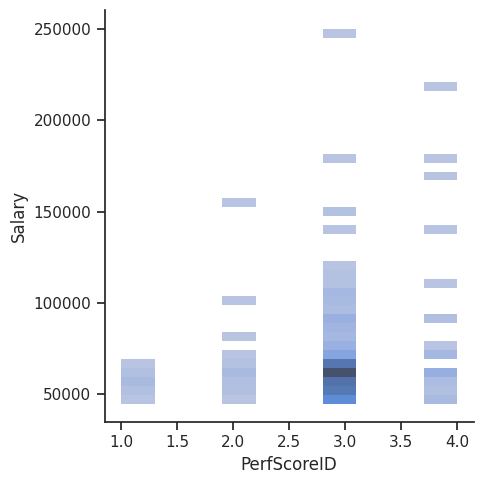

In [23]:
ax = sns.displot(df, x='PerfScoreID', y='Salary')

From the graph it can be seen that there is a positive correlation between performance score of the employee and his/her salary. It can also be seen that most employees have scored 3. I will prove this hypothesis by numeric analysis.

*Also, it is clearly visible that there are some outliers, such as CEO, whos salary is much greater than others. I will remove him and some other employees with extremely high salaries from some parts of my analysis.


/tmp/ipykernel_13871/2052006447.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_by_perf.mean()['Salary']


PerfScoreID
1    57956.000000
2    63196.235294
3    66514.728033
4    67217.941176
Name: Salary, dtype: float64

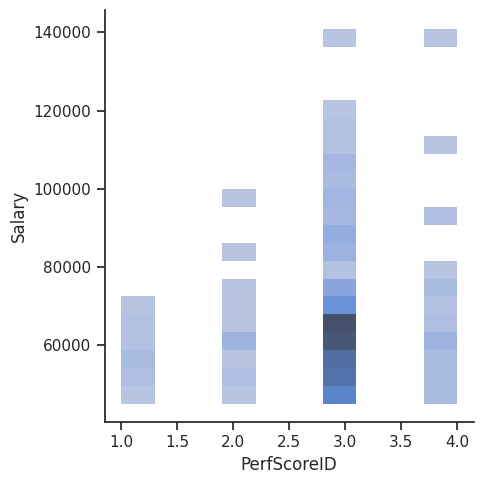

In [24]:
z = np.abs(stats.zscore(df['Salary']))
df_zscored = df[z < 3]
ax = sns.displot(df_zscored, x='PerfScoreID', y='Salary')
grouped_by_perf = df_zscored.groupby('PerfScoreID')
grouped_by_perf.mean()['Salary']

Then I would like to take a look a the Engagement survey column and find out if it correlates with employees salaries.

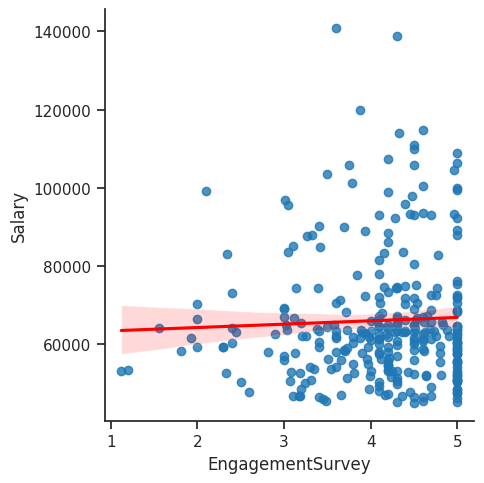

In [25]:
sns.set_palette('tab10')
ax = sns.lmplot(df_zscored, x='EngagementSurvey', y='Salary', line_kws={'color': 'red'})

As it can be seen, there is a little positive correlation between the results of engagement survey and the salary of employees.

Now I would also like to check if there is a correlation between absence rate and salary.

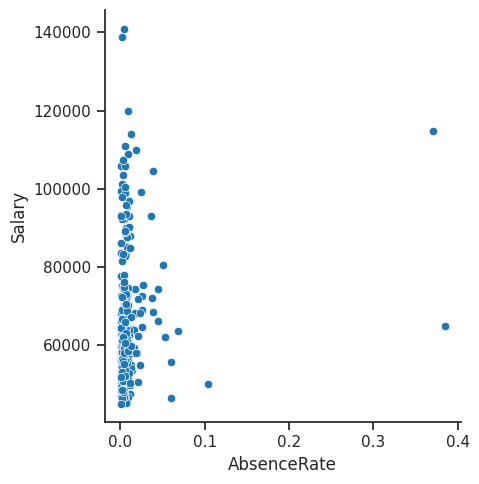

In [26]:
ax = sns.relplot(df_zscored, x='AbsenceRate', y='Salary')

As it can be seen, there are some outliers that make correlation less visible on this plot.
I will remove them as I did with salaries and make a plot without them.


/tmp/ipykernel_13871/2470782726.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_absence_zscored = df_zscored[abscence_z < 2]


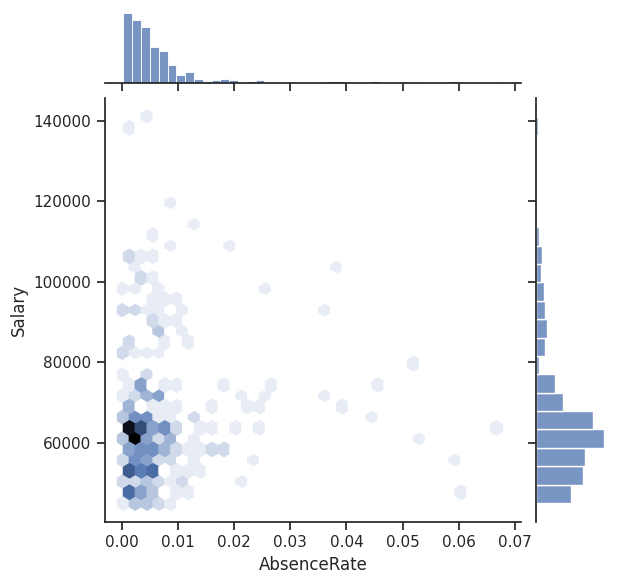

In [27]:
abscence_z = np.abs(stats.zscore(df['AbsenceRate']))
df_absence_zscored = df_zscored[abscence_z < 2]
sns.set_theme(style="ticks")
ax = sns.jointplot(df_absence_zscored, x='AbsenceRate', y='Salary', kind="hex")

I would also like to check the following hypothesis: people who are single spend more time and effort on their job and get more satisfaction and higher salary from their jobs.
From the barchart it can be seen that in three last columns (higher job satisfaction) there are single people who earn the greatest salaries.

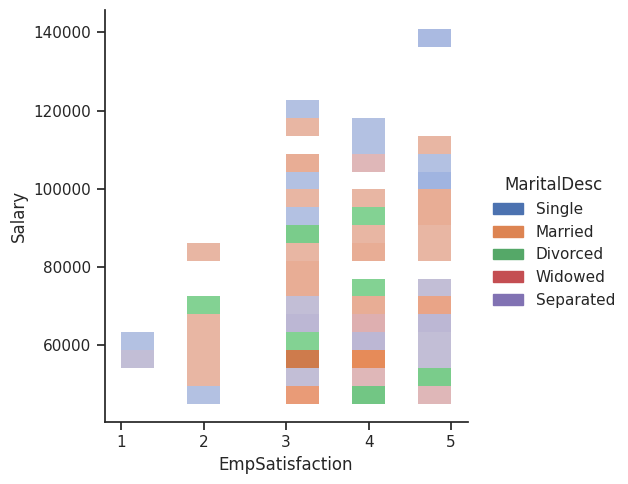

In [28]:
ax = sns.displot(df_zscored, x='EmpSatisfaction', y='Salary', hue='MaritalDesc')

To make this observation more clearly visible, I will convert the Marital Status column to binary (Single/Not Single)

/tmp/ipykernel_13871/1414672238.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_zscored['MaritalBinary'] = df['MaritalDesc'] == 'Single'


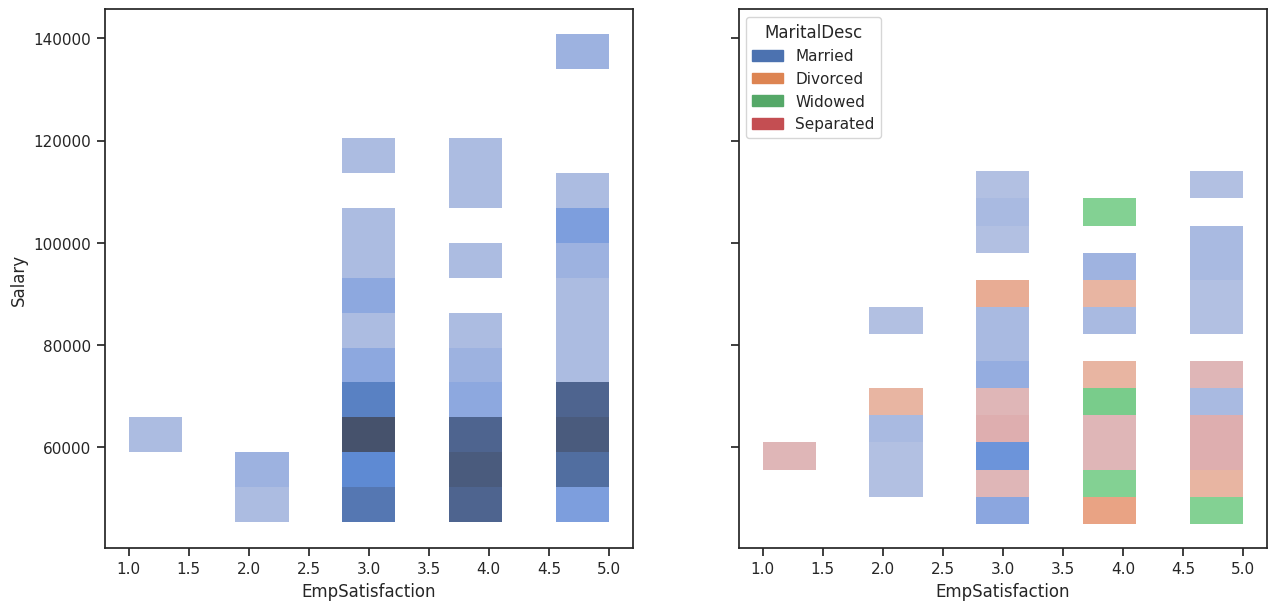

In [54]:
df_zscored['MaritalBinary'] = df['MaritalDesc'] == 'Single'

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 7))
axes = axes.flatten()
sns.histplot(df_zscored[df_zscored['MaritalBinary']], x='EmpSatisfaction', y='Salary', ax=axes[0])
sns.histplot(df_zscored[df_zscored['MaritalBinary'] == False], x='EmpSatisfaction', y='Salary', hue='MaritalDesc',
             ax=axes[1])
sns.move_legend(axes[1], "upper left")
